# IMPORTING Libraries

In [1]:
%%capture
import sys

!pip install category_encoders==2.*
!pip install pdpbox



In [2]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Creating the Wrangle Function

In [3]:
# Data cleaning and Wrangle Function

# Train Data Set
def trainwrangle(filepath):
    # Read in the CSV file
  df = pd.read_csv(filepath, index_col='Loan_ID')

  # Turning my target into 1 and 0s
  # Dropping NaN Values from my Target column
  df['Loan_Status'] = (df['Loan_Status'] == 'Y').astype(int)
  df.dropna(subset=['Loan_Status'], inplace = True)

  # Label Encoding Columns so they are represent by numbers
  df['Gender'] = df['Gender'].map({'Male':1, 'Female':0})
  df['Married'] = df['Married'].map({'Yes':1, 'No':0})
  df['Dependents'] = df['Dependents'].map({'0':0, '1':1, '2':2, '3+':3})
  df['Education'] = df['Education'].map({'Graduate':1, 'Not Graduate':0})
  df['Self_Employed'] = df['Self_Employed'].map({'Yes':1, 'No':0})
  df['Property_Area'] = df['Property_Area'].map({'Rural':0, 'Semiurban':1, 'Urban':2})


  # Filling NaN values
  df['Gender'].fillna(df['Gender'].median(),inplace=True)
  df['Married'].fillna(df['Married'].median(),inplace=True)
  df['Dependents'].fillna(df['Dependents'].median(),inplace=True)
  df['Self_Employed'].fillna(df['Self_Employed'].median(),inplace=True)
  df['LoanAmount'].fillna(df['LoanAmount'].mean(),inplace=True)
  df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(),inplace=True)
  df['Credit_History'].fillna(df['Credit_History'].median(),inplace=True)

  df.drop(columns=['LoanAmount','Loan_Amount_Term','Property_Area'], inplace=True)


  return df 


def testwrangle(filepath):
  # Read in the CSV file
  df = pd.read_csv(filepath, index_col='Loan_ID')
  
  # Label Encoding Columns so they are represent by numbers
  df['Gender'] = df['Gender'].map({'Male':1, 'Female':0})
  df['Married'] = df['Married'].map({'Yes':1, 'No':0})
  df['Dependents'] = df['Dependents'].map({'0':0, '1':1, '2':2, '3+':3})
  df['Education'] = df['Education'].map({'Graduate':1, 'Not Graduate':0})
  df['Self_Employed'] = df['Self_Employed'].map({'Yes':1, 'No':0})
  df['Property_Area'] = df['Property_Area'].map({'Rural':0, 'Semiurban':1, 'Urban':2})


  # Filling NaN values
  df['Gender'].fillna(df['Gender'].median(),inplace=True)
  df['Married'].fillna(df['Married'].median(),inplace=True)
  df['Dependents'].fillna(df['Dependents'].median(),inplace=True)
  df['Self_Employed'].fillna(df['Self_Employed'].median(),inplace=True)
  df['LoanAmount'].fillna(df['LoanAmount'].mean(),inplace=True)
  df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(),inplace=True)
  df['Credit_History'].fillna(df['Credit_History'].median(),inplace=True)

  df.drop(columns=['LoanAmount','Loan_Amount_Term','Property_Area'], inplace=True)

  return df

df = trainwrangle('loan-train.csv')
X_test = testwrangle('loan-test.csv')

# Exploring my data

In [4]:
df.head(100)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Credit_History,Loan_Status
Loan_ID,,,,,,,,,
LP001002,1.0,0.0,0.0,1,0.0,5849,0.0,1.0,1
LP001003,1.0,1.0,1.0,1,0.0,4583,1508.0,1.0,0
LP001005,1.0,1.0,0.0,1,1.0,3000,0.0,1.0,1
LP001006,1.0,1.0,0.0,0,0.0,2583,2358.0,1.0,1
LP001008,1.0,0.0,0.0,1,0.0,6000,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...
LP001326,1.0,0.0,0.0,1,0.0,6782,0.0,1.0,0
LP001327,0.0,1.0,0.0,1,0.0,2484,2302.0,1.0,1
LP001333,1.0,1.0,0.0,1,0.0,1977,997.0,1.0,1


In [5]:
# Checking the Shape of the Dataset
df.shape

(614, 9)

In [6]:
# Checking out Info on the Dataset
df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Credit_History,Loan_Status
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.817590,0.653094,0.744300,0.781759,0.133550,5403.459283,1621.245798,0.855049,0.687296
std,0.386497,0.476373,1.009623,0.413389,0.340446,6109.041673,2926.248369,0.352339,0.463973
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2877.500000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3812.500000,1188.500000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,5795.000000,2297.250000,1.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,41667.000000,1.000000,1.000000


In [7]:
# Checking total Null Values
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
Credit_History       0
Loan_Status          0
dtype: int64

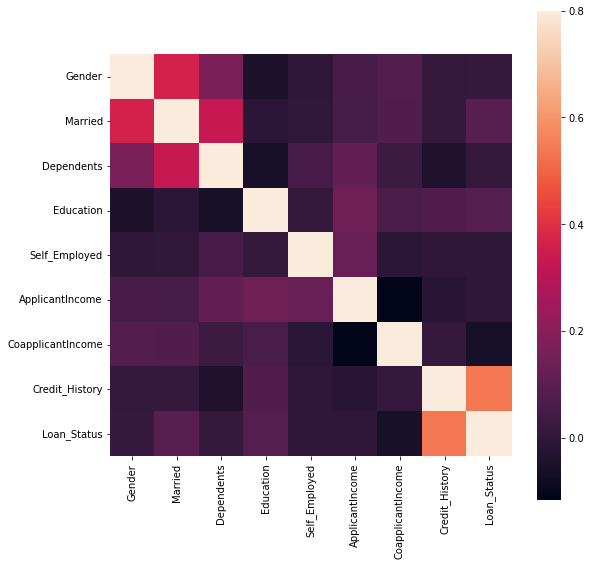

In [8]:
# Plotting Feature Correlation
corrmat=df.corr()
f,ax=plt.subplots(figsize=(9,9))
sns.heatmap(corrmat,vmax=.8,square=True)

# Splitting the data

In [9]:
# Splitting into my X Matrix and y vector
target = 'Loan_Status'
y = df[target]
X = df.drop(target, axis=1)


In [10]:
# Using a random train test split
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state = 1)

In [11]:
# Baseline Accuracy
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.6883910386965377


#Building the Models

Training Accuracy (LOGR): 0.814663951120163
Validation Accuracy (LOGR): 0.7967479674796748
              precision    recall  f1-score   support

           0       0.89      0.41      0.56        39
           1       0.78      0.98      0.87        84

    accuracy                           0.80       123
   macro avg       0.83      0.69      0.71       123
weighted avg       0.82      0.80      0.77       123



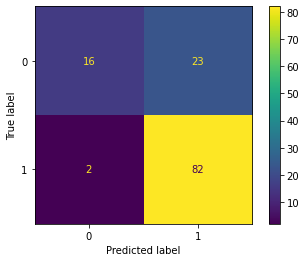

In [12]:
# Model 1: Logistic Regression
model_lr = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train,y_train);

# Print Accuracy Scores for Train and Val
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

# Print Class report and Plot confusion Matrix
print(classification_report(y_val, model_lr.predict(X_val)))
plot_confusion_matrix(model_lr, X_val, y_val);

Training Accuracy (DT): 0.8167006109979633
Validation Accuracy (DT): 0.7967479674796748
              precision    recall  f1-score   support

           0       0.89      0.41      0.56        39
           1       0.78      0.98      0.87        84

    accuracy                           0.80       123
   macro avg       0.83      0.69      0.71       123
weighted avg       0.82      0.80      0.77       123



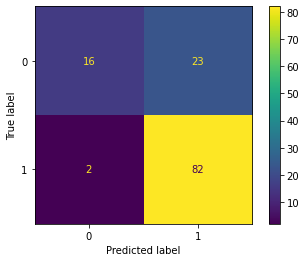

In [13]:
# Model 2: Decision Tree
model_dt = make_pipeline(
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(random_state=1, max_depth=2)
)

model_dt.fit(X_train, y_train);

# Print Accuracy Scores for Train and Val
print('Training Accuracy (DT):', model_dt.score(X_train, y_train))
print('Validation Accuracy (DT):', model_dt.score(X_val, y_val))

# Print Class report and Plot confusion Matrix
print(classification_report(y_val, model_dt.predict(X_val)))
plot_confusion_matrix(model_dt, X_val, y_val);

Training Accuracy (RF): 0.8105906313645621
Validation Accuracy (RF): 0.8048780487804879
              precision    recall  f1-score   support

           0       0.89      0.41      0.56        39
           1       0.78      0.98      0.87        84

    accuracy                           0.80       123
   macro avg       0.83      0.69      0.71       123
weighted avg       0.82      0.80      0.77       123



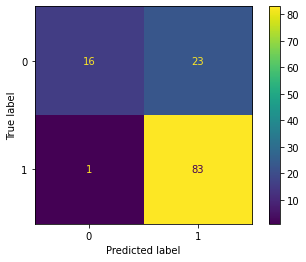

In [14]:
# Model 3: Random Forest
model_rf = make_pipeline(
    RandomForestClassifier(max_depth=10,n_estimators=75, random_state=1, n_jobs=-1,max_features=5,max_leaf_nodes=113,min_samples_leaf=25),                     


)
model_rf.fit(X_train,y_train);


# Print Accuracy Scores for Train and Val
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

# Print Class report and Plot confusion Matrix
print(classification_report(y_val, model_lr.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_val);



Training Accuracy (RF): 0.8105906313645621
Validation Accuracy (RF): 0.8048780487804879
              precision    recall  f1-score   support

           0       0.94      0.41      0.57        39
           1       0.78      0.99      0.87        84

    accuracy                           0.80       123
   macro avg       0.86      0.70      0.72       123
weighted avg       0.83      0.80      0.78       123



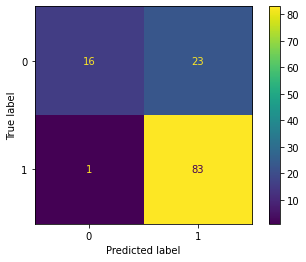

In [15]:
# Model 4: XG BOOST
model_xg = make_pipeline(
    XGBClassifier(random_state=42, n_estimators=15,n_jobs=-1,max_depth=2,),)                     


model_xg.fit(X_train,y_train);


# Print Accuracy Scores for Train and Val
print('Training Accuracy (RF):', model_xg.score(X_train, y_train))
print('Validation Accuracy (RF):', model_xg.score(X_val, y_val))

# Print Class report and Plot confusion Matrix
print(classification_report(y_val, model_xg.predict(X_val)))
plot_confusion_matrix(model_xg, X_val, y_val);

Training Accuracy (RF): 0.8513238289205702
Validation Accuracy (RF): 0.7967479674796748
              precision    recall  f1-score   support

           0       0.89      0.41      0.56        39
           1       0.78      0.98      0.87        84

    accuracy                           0.80       123
   macro avg       0.83      0.69      0.71       123
weighted avg       0.82      0.80      0.77       123



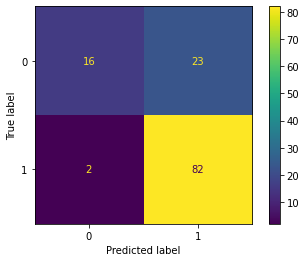

In [16]:
# Model 5: Gradiant Boost
model_gb = make_pipeline(
    GradientBoostingClassifier(random_state=42, n_estimators=75, learning_rate=0.1),                     


)
model_gb.fit(X_train,y_train);


# Print Accuracy Scores for Train and Val
print('Training Accuracy (RF):', model_gb.score(X_train, y_train))
print('Validation Accuracy (RF):', model_gb.score(X_val, y_val))

# Print Class report and Plot confusion Matrix
print(classification_report(y_val, model_gb.predict(X_val)))
plot_confusion_matrix(model_gb, X_val, y_val);

# Hyper Tuning Two of the Models

In [17]:
# DECICION TREE HYPERPARAMETER TUNING
max_iters = range(100,200,10)

train_acc = []
val_acc = []

for iters in max_iters:
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      LogisticRegression(max_iter=iters, random_state=42)
  )

  tree_model.fit(X_train, y_train)

  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

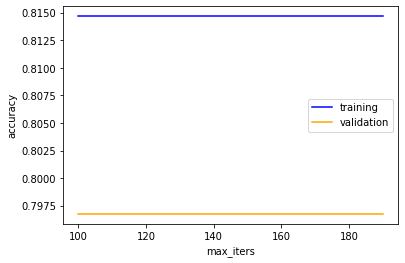

In [18]:
plt.plot(max_iters, train_acc, color='blue', label='training')
plt.plot(max_iters, val_acc, color='orange', label='validation')

plt.xlabel('max_iters')
plt.ylabel('accuracy')
plt.legend();

In [19]:

# Parameter Tuning for Random Forest
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=25, random_state=42)
)

param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(5,40,5),
    'randomforestclassifier__n_estimators': range(25, 125, 25),
    'randomforestclassifier__max_leaf_nodes': range(1, 125, 1),
    'randomforestclassifier__min_samples_leaf': range(5, 125, 5),
    'randomforestclassifier__max_features': range(1, 10, 1)
}

model_rfrs = RandomizedSearchCV(
    clf, 
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model_rfrs.fit(X_train, y_train)




Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_estimators=25,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 40, 5),
                                        'randomforestclassifier__max_features': range(1, 10),
                                        'randomforestclassifier__max_leaf_nodes': range(1, 125),
                                        'randomforestclassifier__min_samples_leaf': range(5, 125, 5),
                                        'randomforestclassifier__n_estimators': range(25, 125, 25),


In [20]:
model_rfrs.best_params_

{'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__max_features': 7,
 'randomforestclassifier__max_leaf_nodes': 95,
 'randomforestclassifier__min_samples_leaf': 15,
 'randomforestclassifier__n_estimators': 100,
 'simpleimputer__strategy': 'mean'}

In [21]:
model_rfrs.best_score_

0.8106575963718822

In [22]:
y_pred = model_rf.predict(X_test)

In [23]:

y_pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

# Communicate Results

## Partial Dependence Plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


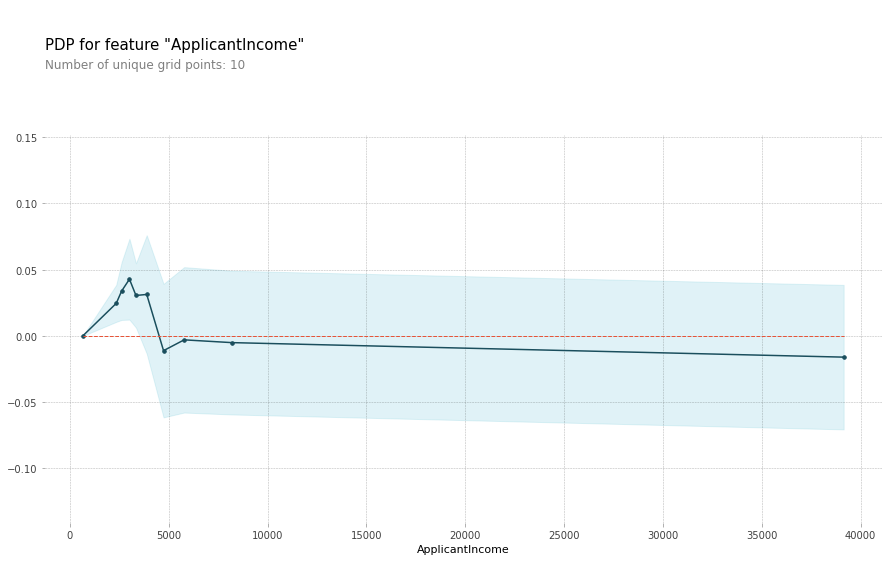

In [24]:


feature = 'ApplicantIncome'

isolate = pdp_isolate(
    model_rf,
    dataset= X_val, # USE YOUR VALIDATION DATA
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolate, feature_name = feature);

In [25]:
print(pd.__file__)

/usr/local/lib/python3.7/dist-packages/pandas/__init__.py


# Downloading Pipeline and Information for PIPENV SHELL

In [26]:
# Creating File
from joblib import dump
dump(model_dt, 'pipeline.joblib',compress=True)

['pipeline.joblib']

In [27]:
# Download File
from google.colab import files
files.download('pipeline.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# getting Versions
import joblib
import sklearn
import category_encoders

print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={category_encoders.__version__}')

joblib==1.1.0
scikit-learn==1.0.1
category_encoders==2.3.0


In [29]:
def predict(Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome,Credit_History):
    df = pd.DataFrame(
        columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome','Credit_History'],
        data=[[Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome,Credit_History]]
    )
    y_pred = model_rf.predict(df)[0]
    return f'{y_pred}'